## What is this competition all about?

* Given seismic signals we are asked to predict the time until the onset of laboratory earthquakes.
* The training data is a single sequence of signal and seems to come from one experiment alone.
* In contrast the test data consists of several different sequences, called segments, that may correspond to different experiments. The regular pattern we might find in the train set does not match those of the test segments. 
* For each test data segment with its corresponding seg_id we are asked to predict it's single time until the lab earthquake takes place.

## What is an earthquake in the lab?

Presently, I don't know how an earthquake in the laboratory works. So I've googled around and found this video that shows how such a lab looks like. If you like, feel free to take a look at it. I'm still on my journey to understand the problem. 

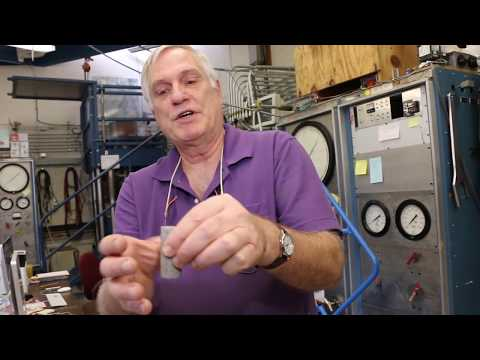

In [25]:
from IPython.display import YouTubeVideo
YouTubeVideo('m_dBwwDJ4uo')

In the end we can see that the probes that are used are put under some kind of **normal pressure but there is a shear stress working on it as well**. Then, after some time, the probe splits. If you take a look at the additional material given, you can see that we have: 

### 3 kind of plates

* 2 plates left and right that are under normal pressure: Forces are acting with 90 degree on the plate, pushing the two plates together. 
* In the middle we find a third plate which is separated by some granular material. This plate moves downwards with constant velocity. 

I'm not sure if I understand this right, but it seems that this granular material is the "rock" that can split and load again to produce this kind of lab earthquakes in repetitive cycles. Even though the train set contains continuous data it contains several such splits (earthquakes).

##Loading Packages

In [26]:
# access kaggle datasets
!pip install kaggle

# math operations
!pip install numpy==1.15.0

# machine learning
!pip install catboost

In [0]:
# data preprocessing
import pandas as pd

# math operations
import numpy as np

# machine learning
from catboost import CatBoostRegressor, Pool

# data scaling
from sklearn.preprocessing import StandardScaler

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV

# support vector machine model
from sklearn.svm import NuSVR, SVR

# kernel ridge model
from sklearn.kernel_ridge import KernelRidge

# data visualization
import matplotlib.pyplot as plt

##Import Dataset from Kaggle

In [28]:
# Colab's file access feature
from google.colab import files

# retrieve uploaded file
uploaded = files.upload()

# print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [29]:
# list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2617           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9973            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4136            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2293            True  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897           False  
LANL-Ear

In [30]:
# download earthquake dataset
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
# unzip training data for usage
!ls
!unzip train.csv.zip
!ls

catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip


##Exploratory Data Analysis

### Let's get familiar with the data!

#### Training data

The total size of the train data is almost 9 GB and we don't want to wait too long just for a first impression, let's load only some rows: 

In [32]:
# extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

# print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


We see two columns: **acoustic_data** and **time_to_failure.** The former is the seismic singal and the latter corresponds to the the time (in seconds) until the next laboratory earthquake takes place. 

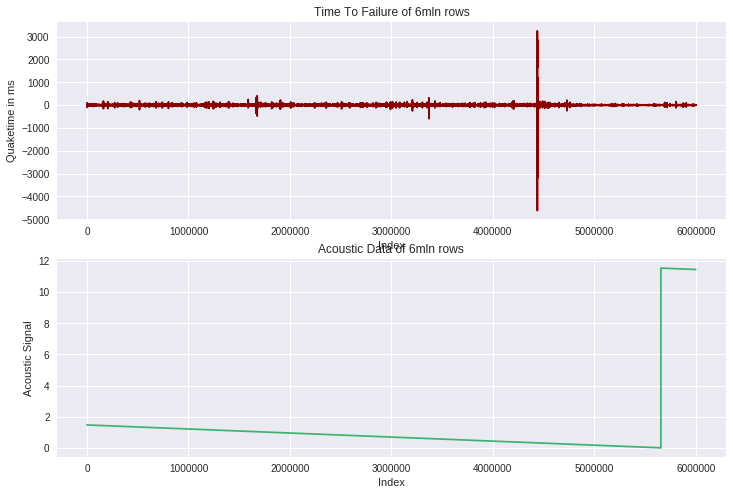

In [33]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(train.index.values, train.acoustic_data.values, c="darkred")
ax[0].set_title("Time To Failure of 6mln rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");
ax[1].plot(train.index.values, train.time_to_failure.values, c="mediumseagreen")
ax[1].set_title("Acoustic Data of 6mln rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

###Observations:

* We can see only one time in 6mln rows when quaketime goes to 0. This is a timepoint where an earthquake in the lab occurs. 
* There are many small oscillations until a heavy peak of the signal occurs. Then it takes some time with smaller oscillations and the earthquake occurs.

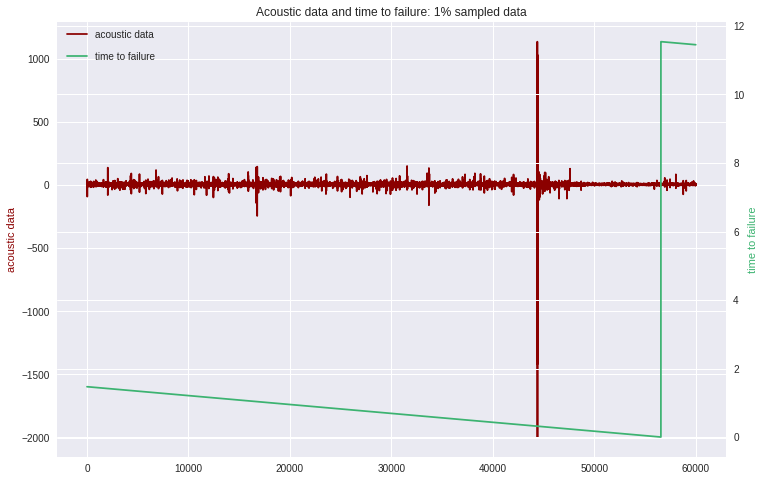

In [34]:
# visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

# function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='darkred')
    ax1.set_ylabel('acoustic data', color='darkred')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='mediumseagreen')
    ax2.set_ylabel('time to failure', color='mediumseagreen')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

##Feature Engineering

In [0]:
## Feature Engineering and signifiance of these statistical features

# let's create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [37]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


##Implement Catboost Model

In [38]:
# model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7804224713035586}}

#Not a great score, given the leaderboard's top 5 are in the mid 1.3 to 1.4

##Implement Support Vector Machine + Radial Basis Function Kernel

In [39]:
# model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}
